In [2]:
#Skyler Szot
#This file create the dataloader, and trains the ResNet18
#nonpretrained model for healthy / apnea+snore task

import os
import pandas as pd
from torchvision.io import read_image

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

training_data = CustomImageDataset('train.csv', './data') #data contains images for all 10 patients
validation_data = CustomImageDataset('test.csv', './data')

In [ ]:
#Create the DataLoader objects

training_loader = DataLoader(training_data, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=16, shuffle=False)

Feature batch shape: torch.Size([16, 3, 219, 337])
Labels batch shape: torch.Size([16])
torch.Size([219, 337, 3])


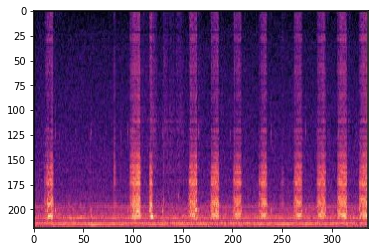

Label: 1


In [3]:
#get an example image to display

train_features, train_labels = next(iter(training_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].squeeze()
label = train_labels[0]

img = img.permute(1,2,0)
print(img.shape)

plt.imshow(img)
plt.show()
print(f"Label: {label}")

In [4]:
def train_classification(model, device, training_loader, validation_loader, batch_size, optimizer, epochs, save_path):

    # clear GPU cache
    torch.cuda.empty_cache()
    
    # initialize empty lists for storing training and validation loss and accuracy
    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []
    
    # initialize highest validation accuracy value
    highest_validation_loss = 1000000
    
    loss_fn = nn.BCELoss() #define loss function
    
    # iterate through epochs
    for epoch in range(epochs):
        print(epoch)
        # initialize training loss and iteration values
        running_loss = 0
        running_vloss = 0
        
        # make sure model is in train mode (dropout activated, weights not frozen, etc.)
        model.train()
        
        correct = 0
        total = 0
        
        # iterate through training epoch
        for i, data in iter(training_loader):

            # transfer images and labels to GPU
            images, labels = i.to(device), data.to(device)
            
            # set the gradients of batch to zero
            optimizer.zero_grad()
            
            #complete forward pass of batch through model
            images_permute = images.float()
            outputs = model(images_permute)
            
            # calculate the loss of the output
            labels = labels.reshape((labels.shape[0], 1)).float()
            loss = loss_fn(F.sigmoid(outputs), labels)
            
            # compute the gradients of the pass
            loss.backward()

            # update the model weights
            optimizer.step()
            
            # update the training loss and accuracy histories
            running_loss += loss.item()
            
            correct += (torch.round(F.sigmoid(outputs)) == labels).float().sum()
            total += len(labels)
            
        accuracy = correct / total
        train_accuracy_history.append(accuracy.item())
        avg_loss = running_loss / (len(data) + 1)
        
        train_loss_history.append(avg_loss)
            
        # initialize validation loss and iteration values
        validation_loss = 0
        iteration = 0
        
        # switch model to evaluation mode
        model.eval()
        
        # iterate through validation epoch
        running_vloss = 0
        correct = 0
        total = 0
        
        for i, vdata in iter(validation_loader):

            # transfer images and labels to GPU
            images, labels = i.to(device), vdata.to(device)
            images_permute = images.float()
            
            # complete forward pass of batch through model
            voutputs = model(images_permute)
            
            # calculate loss
            labels = labels.reshape((labels.shape[0], 1)).float()
            vloss = loss_fn(F.sigmoid(voutputs), labels)

            # update the validation loss and accuracy histories
            running_vloss += vloss.item()
            
            correct += (torch.round(F.sigmoid(voutputs)) == labels).float().sum()
            total += len(labels)
            
        accuracy = correct / total
        val_accuracy_history.append(accuracy.item())
        avg_vloss = running_vloss / (len(data) + 1)
        val_loss_history.append(avg_vloss)
        
        # if validation accuracy is higher than previous highest, save model weights and update highest val accuracy value
        if epoch > 0:
            if avg_vloss < highest_validation_loss:
                highest_validation_loss = avg_vloss #new best loss value
                model_path = './models/model.pth'
                torch.save(model.state_dict(), model_path)
       
    # return training and validation loss and accuracy histories
    return train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history

In [3]:
device = torch.device('cuda')
print("GPU name: ", torch.cuda.get_device_name(0))

GPU name:  NVIDIA GeForce RTX 2060


In [7]:
resnet18 = torchvision.models.resnet18(pretrained=False)
resnet18.fc = torch.nn.Linear(512, 1) #just 1 output, will use sigmoid later
resnet18.to(device)

batch_size = 16
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.0003)

epochs = 15
save_path = './models'

train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history = train_classification(resnet18, device, training_loader, validation_loader, batch_size, optimizer, epochs, save_path)

print("train_loss_history: ", train_loss_history)
print("train_accuracy_history: ", train_accuracy_history)
print("val_loss_history: ", val_loss_history)
print("val_accuracy_history: ", val_accuracy_history)

0


C:\Users\Skyler\anaconda3\envs\edge\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


1
2
3
4
5
6
7
8
9
10
11
12
13
14
train_loss_history:  [218.9505979610607, 102.34789632670581, 67.59159405375831, 52.567096836317795, 41.229570366290865, 35.5343252347724, 29.55002365745604, 25.263538014749066, 22.525878032957554, 19.389261131833337, 18.020712733554138, 16.434077896922098, 15.706525385566056, 13.327853471350597, 13.23591090444479]
train_accuracy_history:  [0.8696999549865723, 0.9469642639160156, 0.9656167030334473, 0.9737226366996765, 0.9794947504997253, 0.9823095202445984, 0.9846967458724976, 0.9871017932891846, 0.9884557723999023, 0.9904332160949707, 0.990932047367096, 0.9919297099113464, 0.9928382635116577, 0.9934974312782288, 0.9942100644111633]
val_loss_history:  [133.03865249485244, 156.92967518359802, 204.5731470973538, 170.28109465006204, 228.82664555672318, 197.3134351997184, 266.09628856081616, 351.55804017584734, 257.60158637259343, 556.2110399783386, 328.8119131052127, 321.09335143686366, 356.23656883042366, 426.5957173813449, 306.5296307844791]
val_accuracy

In [8]:
def plot_loss_and_accuracy(loss, accuracy, title, labels):
    
    _, ax1 = plt.subplots(figsize=(10, 8))
    ax2 = ax1.twinx()

    ax1.plot(loss, color='blue')
    ax2.plot(accuracy, color='orange')
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Loss")
    ax1.legend([labels[1]], loc='best')
    ax2.set_ylabel("Accuracy")
    ax2.legend([labels[0]], loc='best')

    plt.title(title)
    plt.show()

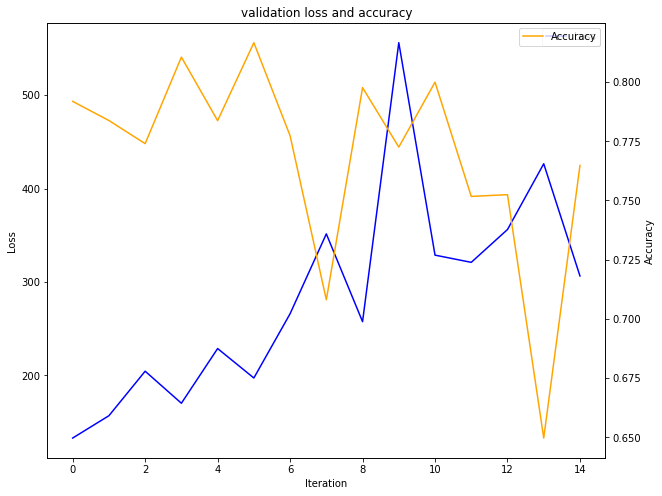

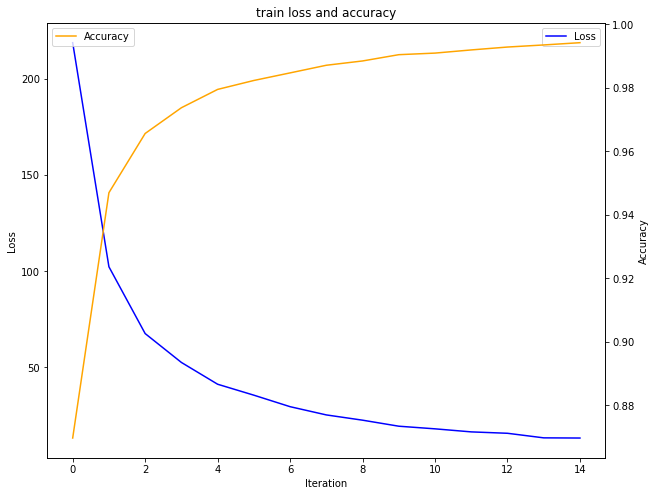

In [9]:
plot_loss_and_accuracy(val_loss_history, val_accuracy_history, "validation loss and accuracy", ["Accuracy", "Loss"])
plot_loss_and_accuracy(train_loss_history, train_accuracy_history, "train loss and accuracy", ["Accuracy", "Loss"])